In [1]:
import pandas as pd
from salmon import *
%matplotlib inline
data = pd.read_csv("./data/harris.csv")
data = data[data['Educ'] != 10].reset_index(drop=True) # Remove single outlier

# _SALMON_

Salmon is a package for symbolic algebra of linear regression and modeling. The goal for this package is to ease the process of model building for linear regression by separating the model (with all its interactions and variables) from the data being used to fit it. 

For the purpose of this documentation we will be using the Harris Bank dataset for our examples.

Using salmon can be defined in three stages:

1. Defining the model
2. Fitting the model
3. Using the model

As such, the documentation will be broken up into these three parts.

# Model Definition

A model is defined by a quatitative or categorical variables existing either stand alone, within interactions, within linear combinations, or a mix of the latter two.

### Variable Types

A variable in this package represts the variables you would commonly see in a definition of a regression model like so:
$$f(\tt{Var}) = \beta_0 + \beta_1 \tt{Var_1} + \beta_2 \tt{Var_2} + \beta_3 \tt{Var_2}^2 + \beta_4 \tt{Var_1}*{Var_2} + \beta_5 \tt{Var_1} * {Var_2}^2$$
where $\tt{Var_i}$ represents either a quantitative or categorical variable. 

Salmon represents these symbolically. When defining the variables, there are three options to pick from:

In [2]:
# Variables known to be quantitative.
quant_var = Q("Bsal")
# Variables known to be categorical.
cat_var = C("Sex")
# Variables of unknown type. These will be interpreted when fitting as either categorical or quantitative.
interp_var = Var("Educ")

The string passed into the variables are the column names to extract from a pandas `DataFrame` when fitting on a set of data. So for instance, if we defined a model with `Q("Bsal")` then the model would extract the `Bsal` column to work with from the data passed in.

#### Quantitative Variables
Common transformations of quantitative variables are also supported. For example:

In [3]:
bsal_squared = Q("Bsal") ** 2
bsal_shifted = Q("Bsal") + 150
bsal_logged = Log(Q("Bsal"))

#### Categorical Variables

When defining categorical variables it is possible to set ahead of time the possible levels/factors to fit with, as well as the encoding method for use. For instance, if we wanted to treat the `Educ` column in our example dataset as a categorical variable, and we knew the possible levels of education were either 8, 10, 12, 15, or 16, then we could define our variable as follows:

In [4]:
educ_var_v1 = C("Educ", method = 'one-hot', levels = [8, 10, 12, 15, 16])
educ_var_v2 = C("Educ", method = 'one-hot', levels = [8, 10, 12])

The first variable defined set the order of the levels to interpreted as. This would matter with encoding methods such as ordinal encoding (note: currently not supported, only one-hot encoding is supported at this time). In our case with the one-hot encoding method used, our ordering designated the '8' level to be dropped to avoid multi-colinearity.

The second variable defined still designated the '8' level to be dropped; however, it also designates that any levels found in the data that are not either '8', '10', or '12' will be binned into an 'other' category.

By default, categorical variables will use a one-hot encoding method and will dynamically extract the possible levels of a variable upon fitting. The levels will be ordered by sorting and the smallest (according to Python's `sorted` function) level will be dropped. 

## Combinations

Many regression applications require multiple variables within the model. This is achieved in salmon by simply adding together several variables. For instance, suppose we wanted to represent:
$$\tt{Sex} + \tt{Bsal} + \tt{Bsal}^2$$
This would be achieved like so:

In [5]:
combo = C("Sex") + Q("Bsal") + Q("Bsal") ** 2

Should you want to define an full polynomial sequence you can use the following command as well:

In [6]:
combo = C("Sex") + Q("Bsal", 4) # Expands to 'Sex + Bsal + Bsal^2 + Bsal^3 + Bsal^4'

## Interactions

It is common to want to model interaction effects between variables. Salmon supports this symbolically using the `*` operator. Any combination of variable type is supported.

For example, let's model this interaction:
$$\tt{Sex * Bsal}$$

In [7]:
interaction = C("Sex") * Q("Bsal")

Here is how we would model a more complicated linear combination of variables and interactions like $$\tt{Sex} + \tt{Bsal} + \tt{Bsal}^2 + \tt{Sex * Bsal} + \tt{Sex}*{Bsal}^2$$


In [8]:
complicated_combo = C("Sex") + Q("Bsal") + Q("Bsal")**2 + C("Sex")*Q("Bsal") + C("Sex")*Q("Bsal")**2

Salmon also supports distribution of singular terms into combinations. The above expression could be represented more succinctly as such:

In [9]:
# Equivalent to C("Sex") + Q("Bsal") + Q("Bsal")**2 + (Q("Bsal") + Q("Bsal")**2) * C("Sex") 
complicated_combo = C("Sex") + Poly("Bsal", 2) + Poly("Bsal", 2) * C("Sex")

## Representing the Model

Now that we understand how to form expressions of variables, we can now represent our models. `LinearModels` are always defined of the form:

`model = LinearModel(explanatory_expression, response_expression)`

The `explanatory_expression` is allowed to be a single term, an interaction, or a combination of the other two. The `response_expression` is allowed to be either a single term or an interaction. Categorical variables are allowed within the `response_expression` so long after encoding the resultant expansion is represented by only one column.

# Fitting the Model

For an example, let us fit this model:

$$\widehat{Sal77}(Sex, Bsal) = \beta_0 + \beta_1 \tt{Sex} + \beta_2 \tt{Bsal} + \beta_3 \tt{Bsal}^2 + \beta_4 \tt{Sex * Bsal} + \beta_5 \tt{Sex}*{Bsal}^2$$

First we must define our model:

In [10]:
explanatory = C("Sex") + Poly("Bsal", 2) + C("Sex") * Poly("Bsal", 2)
response = Q("Sal77")
model = LinearModel(explanatory, response)

Note how we did not need a term for the $\beta_0$ (the intercept). This is because it is not a part of our explantory expression of variables, but rather inherent in the model definition. Should we have wanted to define our model without an intercept, we would define it as `LinearModel(explanatory, response, intercept = False)`

Now that we have our model defined, we must fit the data to it for it to compute all $\beta_i$ values. We do this like so:

In [11]:
model.fit(data)

,Coefficients,SE,t,p
Intercept,15244.585697,15004.866623,1.015976,0.312491
Sex::Male,-15746.353511,20175.689005,-0.780462,0.437262
Bsal,-2.333748,5.847857,-0.399078,0.690825
(Bsal)^2,0.000242,0.000566,0.427475,0.670102
{Bsal}{Sex::Male},5.472859,7.291904,0.750539,0.454979
{(Bsal)^2}{Sex::Male},-0.000423,0.000666,-0.636137,0.526377


Notice how we did not designate datasets separately for the explantory and response. The model assumed all variables used when defined will be found within the one `DataFrame` passed in as an argument. Also notice how we did not have to transform our original dataset to include the transformations and interactions. This was all done interally at runtime while fitting the data to the model.

# Using the Model

Now that our model is fit, we can do a variety of things with it.

First off, the most common use of a model would be to make predictions with new data. This would be done like so:

In [12]:
model.predict(data)

,Predicted Sal77
0,10714.633449
1,12079.759519
2,11806.937185
3,11806.937185
4,11806.937185
5,12488.612620
6,13031.467692
7,11806.937185
8,11806.937185
9,12527.514782


The only restriction is that the new `DataFrame` being passed in must have enough columns with the necessary names used to define the model originally.

## Plotting

Should the model's definition fall under certain categories, plotting the original training data against the linear fit is available as well. As of right now, plotting supports models with explantory expressions consisting of only categorical variables, or expressions consisting of only one quantitative variable and zero or more categorical variables. Some example plots would look as follows:

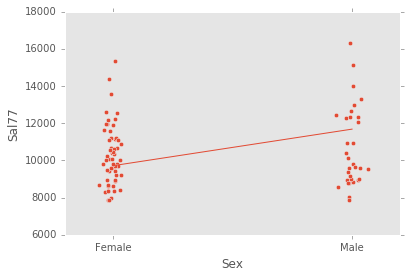

In [13]:
ex_explanatory = C("Sex")
ex_response = Q("Sal77")
ex_model = LinearModel(ex_explanatory, ex_response)
ex_model.fit(data)
ex_model.plot()

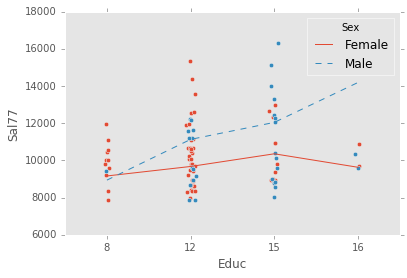

In [14]:
ex_explanatory = C("Sex") + C("Educ") + C("Sex") * C("Educ")
ex_response = Q("Sal77")
ex_model = LinearModel(ex_explanatory, ex_response)
ex_model.fit(data)
ex_model.plot()

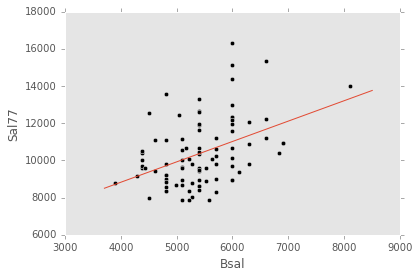

In [15]:
ex_explanatory = Q("Bsal")
ex_response = Q("Sal77")
ex_model = LinearModel(ex_explanatory, ex_response)
ex_model.fit(data)
ex_model.plot()

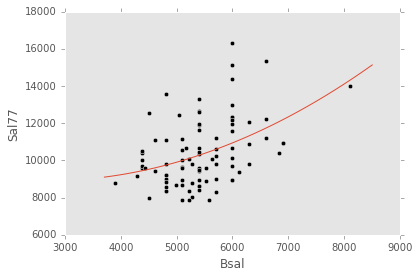

In [16]:
ex_explanatory = Poly("Bsal", 2)
ex_response = Q("Sal77")
ex_model = LinearModel(ex_explanatory, ex_response)
ex_model.fit(data)
ex_model.plot()

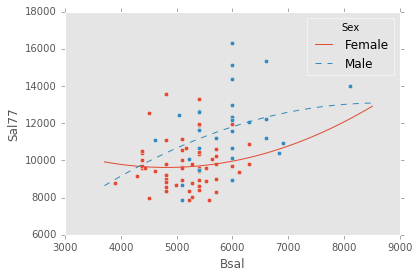

In [17]:
ex_explanatory = C("Sex") + Poly("Bsal", 2) + C("Sex") * Poly("Bsal", 2)
ex_response = Q("Sal77")
ex_model = LinearModel(ex_explanatory, ex_response)
ex_model.fit(data)
ex_model.plot()

## Diagnostics

There are two main diagnostic tools that salmon offers to allow you to evaluate the performance of your model and assure that no assumptions are broken: residual plots and partial regression plots. They can be accessed like so:

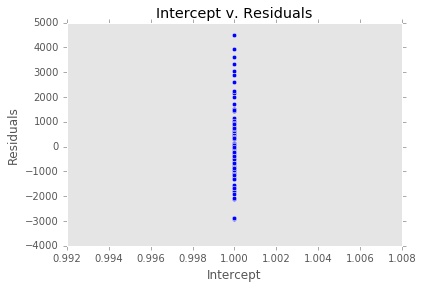

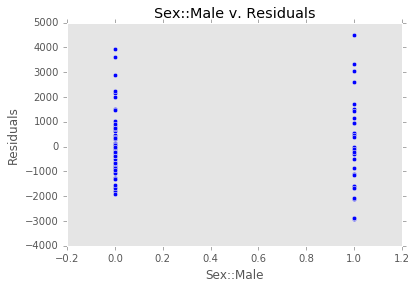

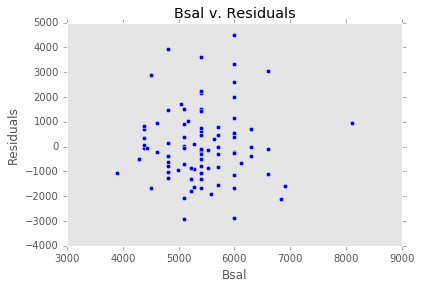

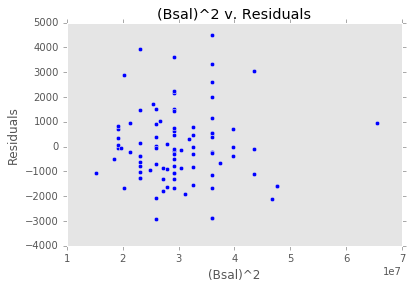

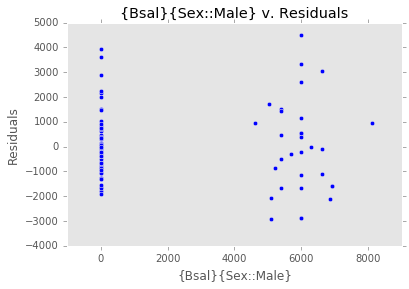

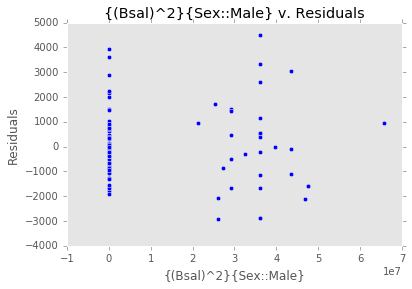

In [18]:
model.residual_plots()

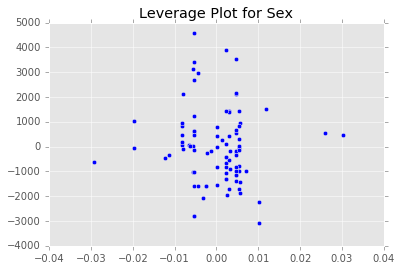

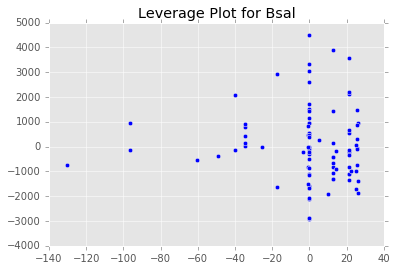

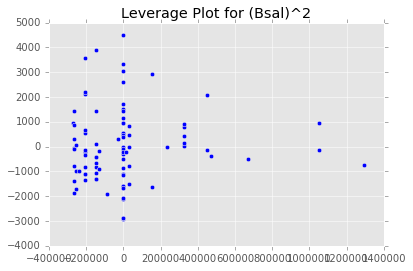

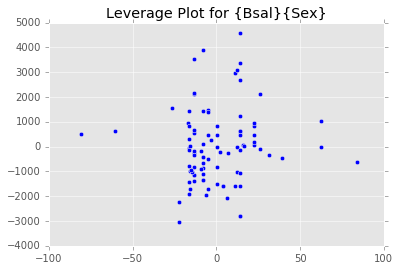

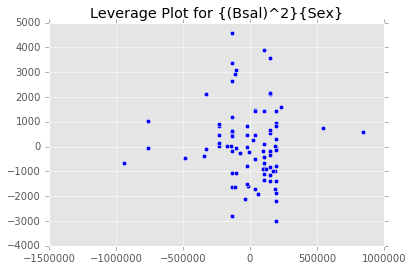

In [19]:
model.partial_plots()